In [35]:
import nannyml as nml
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [36]:
# display max rows and columns
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


In [81]:
tp_cost = -6
tn_cost = -1
fp_cost = 100
fn_cost = 6

cost_matrix = np.array([[tn_cost, fp_cost], [fn_cost, tp_cost]])

In [82]:
reference_df = nml.load_synthetic_binary_classification_dataset()[0]
analysis_df = nml.load_synthetic_binary_classification_dataset()[1]
analysis_targets = nml.load_synthetic_binary_classification_dataset()[2]

#merge analysis targets with analysis df
full_analysis_df = pd.merge(analysis_df, analysis_targets, on='identifier')


chunker = nml.SizeBasedChunker(chunk_size=5000)

estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='work_home_actual',
    timestamp_column_name='timestamp',
    metrics=["business_cost"],
    #chunk_size=5000,
    chunker=chunker,
    problem_type='classification_binary',
    business_cost_matrix = cost_matrix,
)

estimator.fit(reference_df)

results = estimator.estimate(analysis_df)

In [83]:
results.data

chunk                                                        \
              key chunk_index start_index end_index start_date end_date   
0        [0:4999]           0           0      4999       None     None   
1     [5000:9999]           1        5000      9999       None     None   
2   [10000:14999]           2       10000     14999       None     None   
3   [15000:19999]           3       15000     19999       None     None   
4   [20000:24999]           4       20000     24999       None     None   
5   [25000:29999]           5       25000     29999       None     None   
6   [30000:34999]           6       30000     34999       None     None   
7   [35000:39999]           7       35000     39999       None     None   
8   [40000:44999]           8       40000     44999       None     None   
9   [45000:49999]           9       45000     49999       None     None   
10       [0:4999]           0           0      4999       None     None   
11    [5000:9999]           1        5000      9999       None     None   
12  [10000:14999]           2       10000     14999       None     None   
13  [15000:19999]           3       15000     19999       None     None   
14  [20000:24999]           4       20000     24999       None     None   
15  [25000:29999]           5       25000     29999       None     None   
16  [30000:34999]           6       30000     34999       None     None   
17  [35000:39999]           7       35000     39999       None     None   
18  [40000:44999]           8       40000     44999       None     None   
19  [45000:49999]           9       45000     49999       None     None   

              true_positive_cost                          \
       period              value sampling_error realized   
0   reference      -14074.071148     211.892386 -14184.0   
1   reference      -14103.641725     211.892386 -14010.0   
2   reference      -14445.165327     211.892386 -14532.0   
3   reference      -14251.440475     211.892386 -14256.0   
4   reference      -14412.178740     211.892386 -14400.0   
5   reference      -14131.241898     211.892386 -14046.0   
6   reference      -14393.493871     211.892386 -14358.0   
7   reference      -14436.194746     211.892386 -14406.0   
8   reference      -14309.115986     211.892386 -14442.0   
9   reference      -14315.456085     211.892386 -14238.0   
10   analysis      -14856.379657     211.892386      NaN   
11   analysis      -14005.144203     211.892386      NaN   
12   analysis      -14027.447489     211.892386      NaN   
13   analysis      -14044.813037     211.892386      NaN   
14   analysis      -14379.089031     211.892386      NaN   
15   analysis      -14584.910073     211.892386      NaN   
16   analysis      -14543.635010     211.892386      NaN   
17   analysis      -14478.933510     211.892386      NaN   
18   analysis      -14299.712870     211.892386      NaN   
19   analysis      -14936.800712     211.892386      NaN   

                                                                        \
   upper_confidence_boundary lower_confidence_boundary upper_threshold   
0              -13438.393990             -14709.748306   -13799.018231   
1              -13467.964567             -14739.318883   -13799.018231   
2              -13809.488169             -15080.842484   -13799.018231   
3              -13615.763317             -14887.117633   -13799.018231   
4              -13776.501582             -15047.855898   -13799.018231   
5              -13495.564740             -14766.919056   -13799.018231   
6              -13757.816713             -15029.171029   -13799.018231   
7              -13800.517588             -15071.871904   -13799.018231   
8              -13673.438828             -14944.793143   -13799.018231   
9              -13679.778927             -14951.133243   -13799.018231   
10             -14220.702499             -15492.056815   -13799.018231   
11             -13369.467045             -14640.821361   -13799.018231   
12  

In [88]:
#filter the results to only include the analysis period
results = results.filter(period = 'analysis')

est_tp = results.data['true_positive_cost']['value']
est_fp = results.data['false_positive_cost']['value']
est_tn = results.data['true_negative_cost']['value']
est_fn = results.data['false_negative_cost']['value']

est_total = results.data['total_cost']['value']

tp_samp_error = results.data['true_positive_cost']['sampling_error']
fp_samp_error = results.data['false_positive_cost']['sampling_error']
tn_samp_error = results.data['true_negative_cost']['sampling_error']
fn_samp_error = results.data['false_negative_cost']['sampling_error']

total_samp_error = results.data['total_cost']['sampling_error']


In [85]:
ana_chunks = chunker.split(full_analysis_df)

In [89]:


tp_realized_cost = []
tn_realized_cost = []
fp_realized_cost = []
fn_realized_cost = []

realized_total_cost = []

for chunk in ana_chunks:
    y_pred = chunk.data['y_pred']
    y_true = chunk.data['work_home_actual']

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    tp_realized_cost.append(tp * tp_cost)
    tn_realized_cost.append(tn * tn_cost)
    fp_realized_cost.append(fp * fp_cost)
    fn_realized_cost.append(fn * fn_cost)

    realized_total_cost.append((tp * tp_cost) + (tn * tn_cost) + (fp * fp_cost) + (fn * fn_cost))



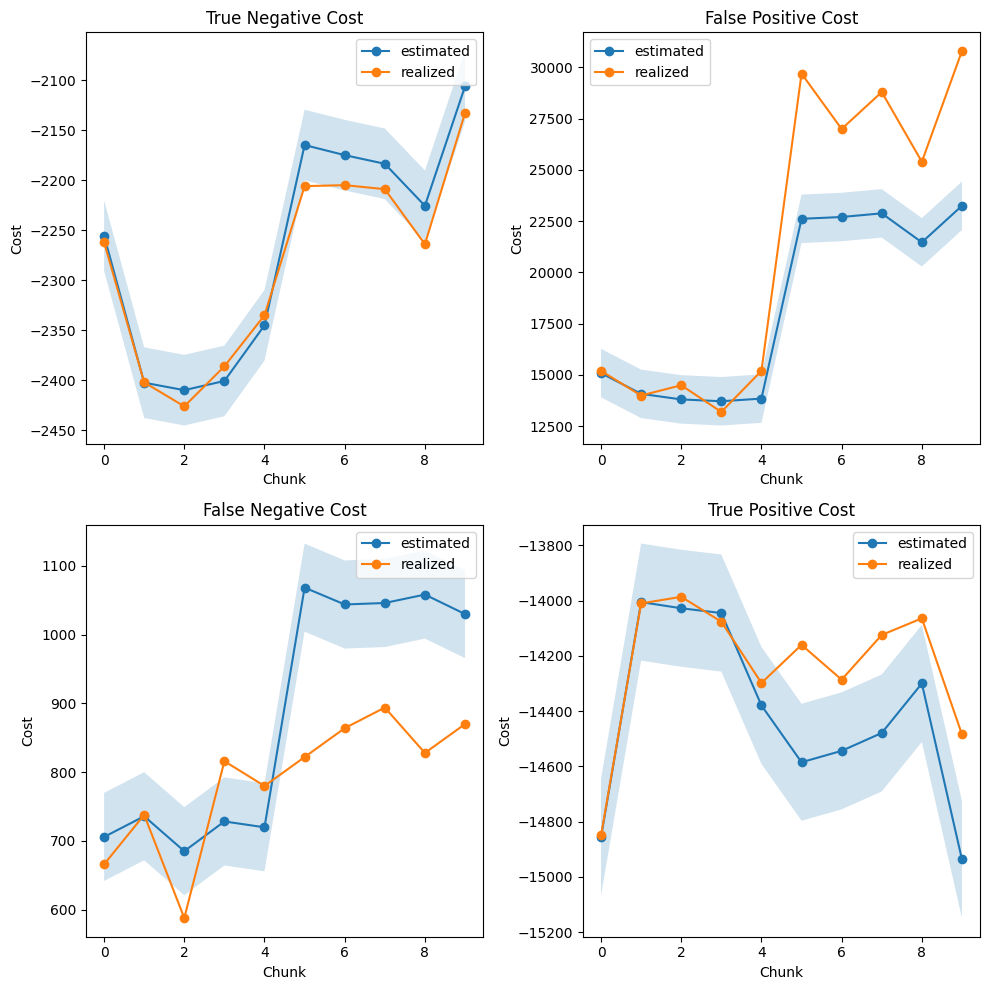

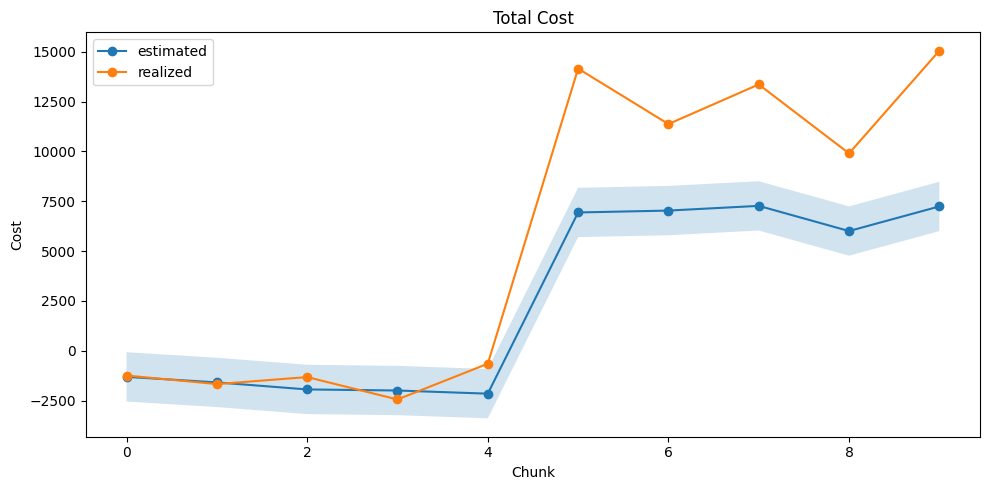

In [95]:
# make a 4 x 4 plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# plot the true positive cost
ax1.plot(est_tn, label='estimated', marker = 'o')
ax1.fill_between(range(len(est_tn)), est_tn - tn_samp_error, est_tn + tn_samp_error, alpha=0.2)
ax1.plot(tn_realized_cost, label='realized', marker = 'o')
ax1.set_title('True Negative Cost')
ax1.set_xlabel('Chunk')
ax1.set_ylabel('Cost')
ax1.legend()

# plot the false positive cost
ax2.plot(est_fp, label='estimated', marker = 'o')
ax2.fill_between(range(len(est_fp)), est_fp - fp_samp_error, est_fp + fp_samp_error, alpha=0.2)
ax2.plot(fp_realized_cost, label='realized', marker = 'o')
ax2.set_title('False Positive Cost')
ax2.set_xlabel('Chunk')
ax2.set_ylabel('Cost')
ax2.legend()

# plot the false negative cost
ax3.plot(est_fn, label='estimated', marker = 'o')
ax3.fill_between(range(len(est_fn)), est_fn - fn_samp_error, est_fn + fn_samp_error, alpha=0.2)
ax3.plot(fn_realized_cost, label='realized', marker = 'o')
ax3.set_title('False Negative Cost')
ax3.set_xlabel('Chunk')
ax3.set_ylabel('Cost')
ax3.legend()

# plot the true negative cost
ax4.plot(est_tp, label='estimated', marker = 'o')
ax4.fill_between(range(len(est_tp)), est_tp - tp_samp_error, est_tp + tp_samp_error, alpha=0.2)
ax4.plot(tp_realized_cost, label='realized', marker = 'o')
ax4.set_title('True Positive Cost')
ax4.set_xlabel('Chunk')
ax4.set_ylabel('Cost')
ax4.legend()

plt.tight_layout()
plt.show()

# plot the total cost
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(est_total, label='estimated', marker = 'o')
ax.fill_between(range(len(est_total)), est_total - total_samp_error, est_total + total_samp_error, alpha=0.2)
ax.plot(realized_total_cost, label='realized', marker = 'o')
ax.set_title('Total Cost')
ax.set_xlabel('Chunk')
ax.set_ylabel('Cost')
ax.legend()
plt.tight_layout()
plt.show()

